In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

from thor_magni_actions.data_modeling.datasets.utils import PixWorldConverter
from thor_magni_actions.data.config import ACTIONS_INFO_PATH

In [2]:
DATASET = "thor_magni"
SCENARIO_ID = "Scenario_5"
PATH = f"thor-magni-actions/data/interim/{DATASET}/{SCENARIO_ID}"

VISUALS_PATH =  "datasets/thor_magni_pub_ready/maps/"

In [3]:
sorted(os.listdir(PATH))

['THOR-Magni_300922_SC5_R1.csv',
 'THOR-Magni_300922_SC5_R2.csv',
 'THOR-Magni_300922_SC5_R3.csv',
 'THOR-Magni_300922_SC5_R4.csv']

In [4]:
FILE = 'THOR-Magni_300922_SC5_R2.csv'

In [5]:
trajectories_df = pd.read_csv(os.path.join(PATH, FILE))
humans_trajectories_df = trajectories_df[trajectories_df.ag_id.str.startswith("Helmet")]
actions_df = pd.read_csv(os.path.join("thor-magni-actions", ACTIONS_INFO_PATH), index_col=0)

In [6]:
actions_df_fn = actions_df.groupby("file_name")
file_actions = actions_df_fn.get_group(FILE)

In [7]:
file_actions

,file_name,qtm_frame_act,ag_id,data_label,action
0,THOR-Magni_300922_SC5_R2.csv,1,Helmet_10,Visitors-Alone,DrawCard
1,THOR-Magni_300922_SC5_R2.csv,2,Helmet_10,Visitors-Alone,DrawCard
2,THOR-Magni_300922_SC5_R2.csv,3,Helmet_10,Visitors-Alone,DrawCard
3,THOR-Magni_300922_SC5_R2.csv,4,Helmet_10,Visitors-Alone,DrawCard
4,THOR-Magni_300922_SC5_R2.csv,5,Helmet_10,Visitors-Alone,DrawCard
...,...,...,...,...,...
22736,THOR-Magni_300922_SC5_R2.csv,23942,Helmet_9,Carrier-StorageBinHRI,Walk
22737,THOR-Magni_300922_SC5_R2.csv,23943,Helmet_9,Carrier-StorageBinHRI,Walk
22738,THOR-Magni_300922_SC5_R2.csv,23944,Helmet_9,Carrier-StorageBinHRI,Walk
22739,THOR-Magni_300922_SC5_R2.csv,23945,Helmet_9,Carrier-StorageBinHRI,Walk


In [8]:
actions_helmets = file_actions["ag_id"].unique()
actions_helmets

array(['Helmet_10', 'Helmet_9'], dtype=object)

In [9]:
act_trajs_dfs = []

for helmet_id in actions_helmets:
    helmet_trajs_df = humans_trajectories_df[
        humans_trajectories_df["ag_id"] == helmet_id
    ]
    helmet_act_df = file_actions[file_actions.ag_id == helmet_id]
    merged_df = pd.merge_asof(
        helmet_trajs_df.sort_values("frame_id"),
        helmet_act_df[["file_name", "qtm_frame_act", "action"]].sort_values("qtm_frame_act"),
        left_on="frame_id",
        right_on="qtm_frame_act",
        direction="nearest",
        # tolerance=None,
    )
    act_trajs_dfs.append(merged_df)

In [10]:
actions_trajs_merged = pd.concat(act_trajs_dfs).set_index("Time").sort_index()

In [11]:
with open(os.path.join(VISUALS_PATH, "offsets.json"), "rb") as f:
    offsets = json.load(f)
    pix2word_converters = dict(
        May=PixWorldConverter(dict(resolution_pm=0.01, offset=offsets["May"])),
        September=PixWorldConverter(dict(resolution_pm=0.01, offset=offsets["September"])),
)

In [12]:
file_info = actions_trajs_merged["file_name"].iloc[0].split("THOR-Magni_")[1]

In [13]:
date, scenario, _ = file_info.split("_")
file_name = date[:4] + "_map.png" 
file_name

'3009_map.png'

In [14]:
month = "May" if date[2:4] == "05" else "September" 

In [15]:
def get_groups_continuous_tracking(dynamic_agent_data: pd.DataFrame):
    """get groups of continuous tracking/no-tracking"""
    mask = dynamic_agent_data[["x", "y"]].isna().any(axis=1)
    groups = (mask != mask.shift()).cumsum()
    groups_of_continuous_tracking = dynamic_agent_data.groupby(groups)
    return groups_of_continuous_tracking

In [16]:
def visualize_actions(actions_trajs_merged: pd.DataFrame):
    all_act = list(actions_trajs_merged["action"].unique())
    actions_colors = plt.cm.get_cmap("tab20", len(all_act))
    helmets = actions_trajs_merged["ag_id"].unique()
    fig, axs = plt.subplots(
        nrows=1, ncols=len(helmets), figsize=(18 * len(helmets), 18)
    )
    lbls = {}
    for i, helmet in enumerate(helmets):
        img = np.array(Image.open(os.path.join(VISUALS_PATH, file_name)))
        spatial_layout = np.flipud(img[:, :, :3])
        ax_handler = axs if len(helmets) == 1 else axs[i]
        ax_handler.imshow(spatial_layout)

        helmet_df = actions_trajs_merged[actions_trajs_merged["ag_id"] == helmet]
        
        helmet_continuous_tracking = get_groups_continuous_tracking(helmet_df)
        lbls[helmet] = {}
        for _, group in helmet_continuous_tracking:
            if group[["x", "y", "z"]].isna().any(axis=0).all():
                continue
            group_pix = pix2word_converters[month].convert2pixels(
                group[["x", "y"]].values
            )
            dis_x = np.diff(group_pix[:, 0]) #/ 0.4
            dis_y = np.diff(group_pix[:, 1]) #/ 0.4
            unique_actions = group["action"].unique()
            idxs = group.reset_index().index
            for act in unique_actions:
                if act not in lbls[helmet]:
                    lbls[helmet][act] = 0
            for action in unique_actions:
                if not isinstance(action, str):
                    continue
                
                lbls[helmet][action] += 1
                idxs_t = idxs[group["action"] == action]
                target_act = group_pix[idxs_t]
                target_dis_x = dis_x[idxs_t - 1] # -1 due to the diff
                target_dis_y = dis_y[idxs_t - 1] # -1 due to the diff
                
                ax_handler.scatter(
                    target_act[:, 0],
                    target_act[:, 1],
                    label=action if lbls[helmet][action] == 1 else "",
                    color=actions_colors(all_act.index(action)),
                    s=150,
                )
                ax_handler.quiver(
                    target_act[:, 0],
                    target_act[:, 1],
                    target_dis_x,
                    target_dis_y,
                    color=actions_colors(all_act.index(action)),
                    angles='xy', scale_units='xy', scale=1
                    # label="Velocity Vectors",
                )
        ax_handler.set_xlim([0, 1900])
        ax_handler.set_ylim([500, 1730])
        ax_handler.legend(prop={"size": 45}, markerscale=3, ncols=2)
        ax_handler.axis("off")
        # if i == 0:

    fig.tight_layout()

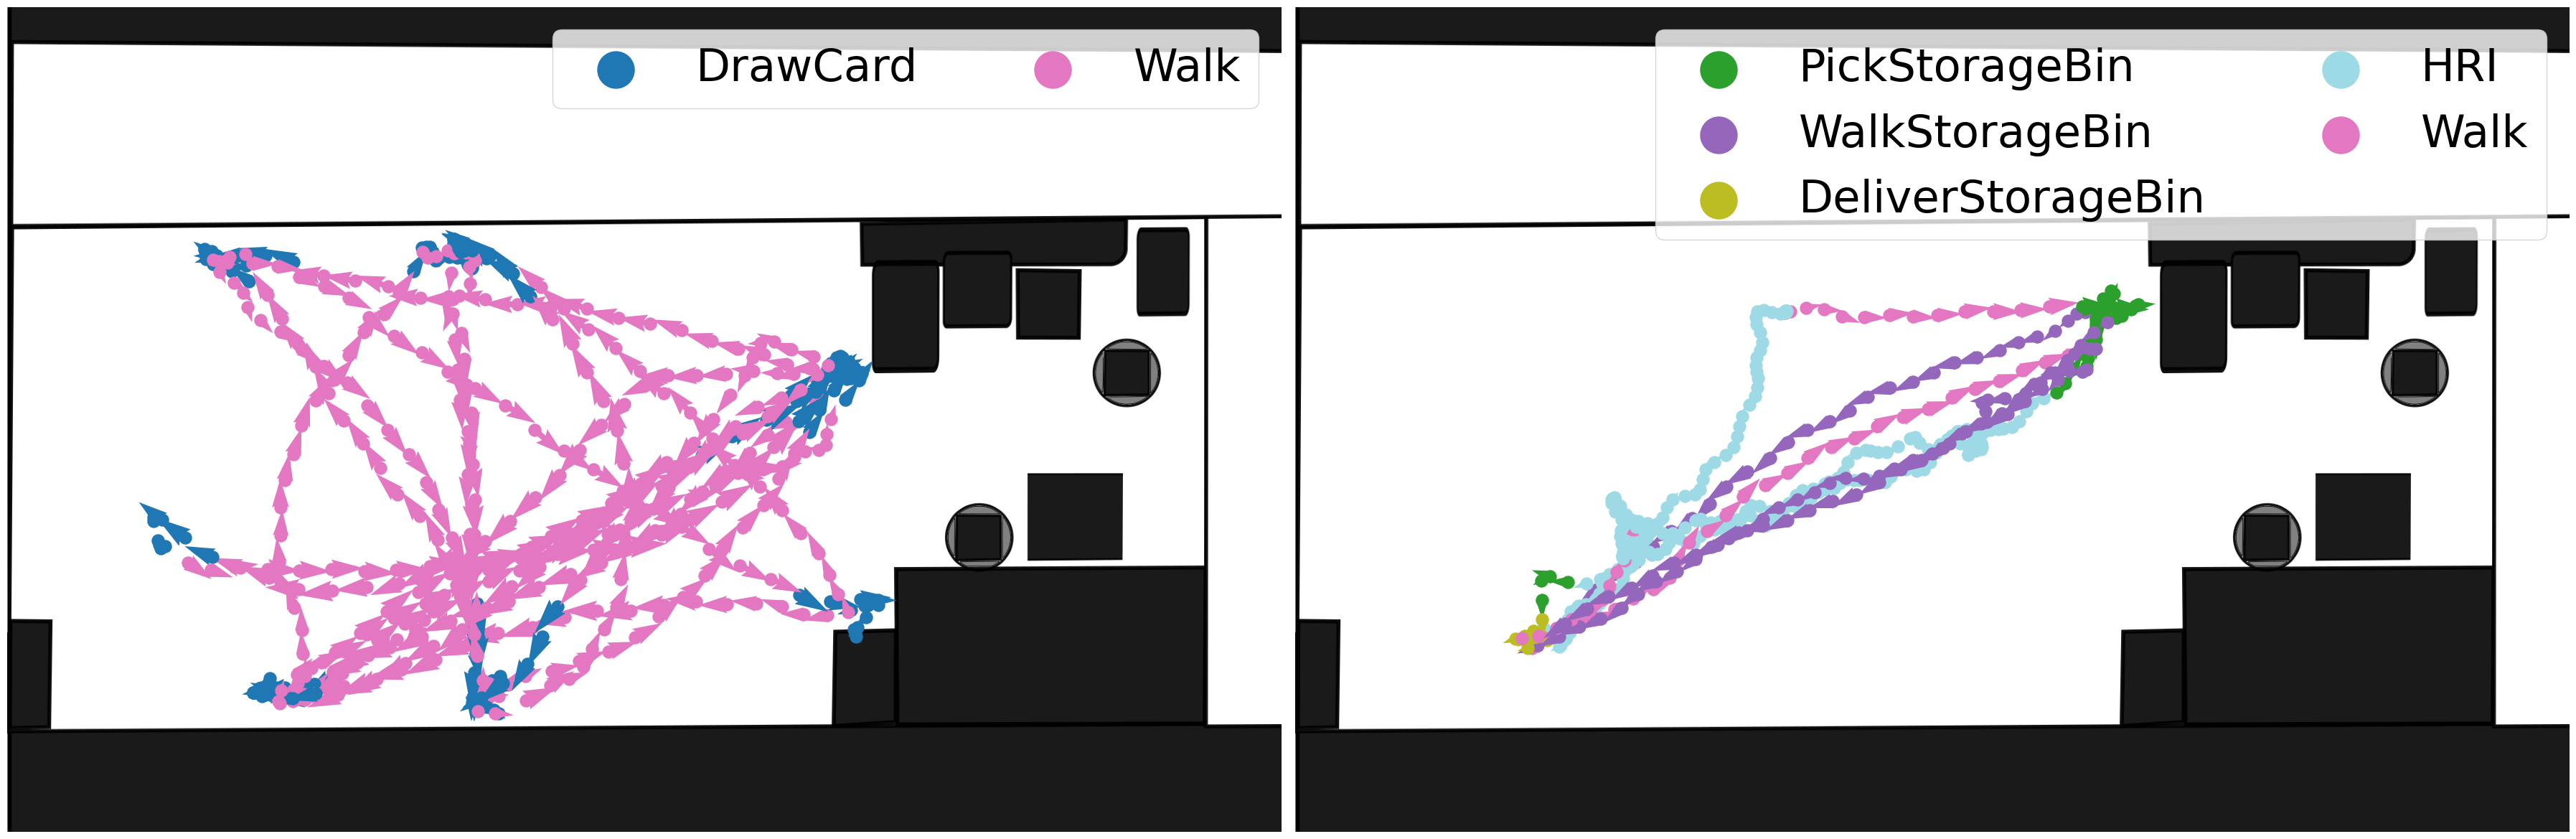

In [17]:
visualize_actions(actions_trajs_merged)